In [1]:
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
# from IPython.display import display, HTML

from pykat import finesse
from pykat.commands import *
pykat.init_pykat_plotting(dpi=90)

from pprint import pprint as pprint

                                              ..-
    PyKat 1.2.2           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [20]:
# base of configurations, without Southern section
basekat = finesse.kat()
basecode = """
# lasers
const Pin 125
const PLO1 1
# spaces
const lx 1.6
const ly 1.55
const Lx 4k
const Ly 4k
const lprc 53
# mirrors
const Tprm 0.3
const Rprm 0.7
const Titm 0.014
const Ritm 0.986
const Tetm 6E-6
const Retm 0.999994
const Tsrm 0.2
const Rsrm 0.8

# carrier laser
l laser $Pin 0 nLaser

# power recycling
m PRM $Rprm $Tprm 0 nLaser nPRM
s sBStoPRM $lprc nPRM nBSi

# central beam splitter
bs BS 0.5 0.5 0 0 nBSi nBSr nBSt nBSo
s sBStoYarm $ly nBSr nY0
s sBStoXarm $lx nBSt nX0

# Y arm (perpendicular)
m mY1 $Ritm $Titm 0 nY0 nY1
s sY $Ly nY1 nY2
m mY2 $Retm $Tetm 0 nY2 nY3

# X arm (parallel)
m mX1 $Ritm $Titm 0 nX0 nX1
s sX $Lx nX1 nX2
m mX2 $Retm $Tetm 0 nX2 nX3

# signal recycling
# nBSo to nSRM left disconnected for now
# is connected differently in kat1 and kat2
m SRM $Rsrm $Tsrm 0 nSRM nDark

# (balanced) homodyne detection
l LO1 $PLO1 0 nLO1
bs hdBS 0.5 0.5 0 0 nDark nhdBSr nhdBSt nLO1
qhd qhd1 180 nhdBSr nhdBSt
hd hd1 180 nhdBSr nhdBSt
"""
basekat.parse(basecode)

pprint((basekat.components, basekat.detectors, basekat.commands))

({'BS': <pykat.components.beamSplitter_345 (BS) at 0x7f043f376278>,
  'LO1': <pykat.components.laser_355 (LO1) at 0x7f0441950fd0>,
  'PRM': <pykat.components.mirror_343 (PRM) at 0x7f043f356da0>,
  'SRM': <pykat.components.mirror_354 (SRM) at 0x7f043f4496d8>,
  'hdBS': <pykat.components.beamSplitter_356 (hdBS) at 0x7f04418da358>,
  'laser': <pykat.components.laser_342 (laser) at 0x7f043f3cb208>,
  'mX1': <pykat.components.mirror_351 (mX1) at 0x7f043f7e7128>,
  'mX2': <pykat.components.mirror_353 (mX2) at 0x7f043f7e7048>,
  'mY1': <pykat.components.mirror_348 (mY1) at 0x7f043f3524e0>,
  'mY2': <pykat.components.mirror_350 (mY2) at 0x7f043f4d4630>,
  'sBStoPRM': <pykat.components.space_344 (sBStoPRM) at 0x7f043f3560f0>,
  'sBStoXarm': <pykat.components.space_347 (sBStoXarm) at 0x7f04418c43c8>,
  'sBStoYarm': <pykat.components.space_346 (sBStoYarm) at 0x7f043f356ba8>,
  'sX': <pykat.components.space_352 (sX) at 0x7f043f7e7518>,
  'sY': <pykat.components.space_349 (sY) at 0x7f043f4d4748>},


In [3]:
def create_kat1(lsrc):
    """ configuration 1: connecting nBSo and nSRM with a space
    lsrc in m
    """
    kat1 = deepcopy(basekat)
    kat1code = """
    const lsrc {0}
    s sBStoSRM $lsrc nBSo nSRM
    """.format(lsrc)
    kat1.parse(kat1code)
    
    return kat1

In [4]:
def create_kat2(lsrc, gain=10):
    """configuration 2: connecting nBSo and nSRM with a nle
    lsrc in m, gain in field dB
    """
    kat2 = deepcopy(basekat)
    kat2code = """
    const lsrc {0}
    const halflsrc {1}
    s sBStonle $halflsrc nBSo nnle11
    nle nle1 {2} 0 nnle11 nnle12 # gain defaults to 10 dB, angle = 0
    s snletoSRM $halflsrc nnle12 nSRM  
    """.format(lsrc, lsrc/2, gain)
    kat2.parse(kat2code)
    
    return kat2

In [ ]:
# rewrite transfer function plotters
# use out.plot(detectors=['qhd1']) etc.

In [5]:
def noise_transfer(kat):
    """calculates QM noise transfer function for created kat1 or kat2"""
    noisekat = deepcopy(kat)
    noisekat.verbose = False
    noisecode = """
    pd darkport nDark
    
    fsig noise 100 # enters through every open port and lossy optic
    xaxis noise f lin 1 10G 1000
    """
    noisekat.parse(noisecode)
    out = noisekat.run()
    
    return out

In [6]:
def gw_transfer(kat):
    """calculates GW signal transfer function for created kat1 or kat2
    currently shakes mX2 at varying frequencies
    
    # how to do differential tuning with fsig?
    
    """
    signalkat = deepcopy(kat)
    signalkat.verbose = False
    signalcode = """
    pd1 darkport 10k 0 nDark
            
    fsig sig1 mX2 10k 0
    xaxis sig1 f lin 1 10G 1000
    
    put darkport f1 $x1
    """
    signalkat.parse(signalcode)
    out = signalkat.run()
    
    return out    

In [7]:
class IFO(object):
    def __init__(self, confignum, lsrc, title, filetag):
        self.lsrc = lsrc
        self.title = title
        self.filetag = filetag
        
        if confignum == 1:
            self.kat = create_kat1(lsrc)
        elif confignum == 2:
            self.kat = create_kat2(lsrc)
        else:
            raise ValueError
            
    def transfer_fn_plots(self):
        noiseplottitle = "noise transfer fn - "
        noisefilename = "noise_transfer_fn"
        noise_transfer(self.kat).plot(title=noiseplottitle+self.title,
                                      filename=noisefilename+self.filetag)
        
        gwplottitle = "gw signal transfer -"
        gwfilename = "gw_signal_transfer_fn"     
        gw_transfer(self.kat).plot(title=gwplottitle+self.title,
                                   filename=gwfilename+self.filetag)        

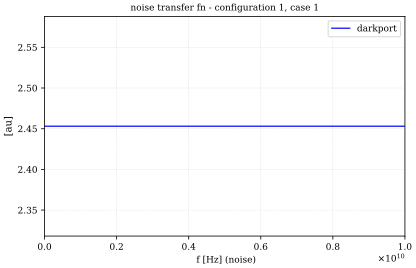

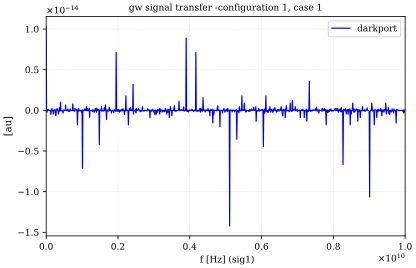

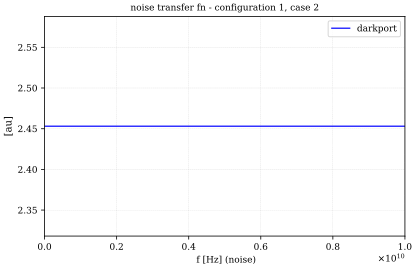

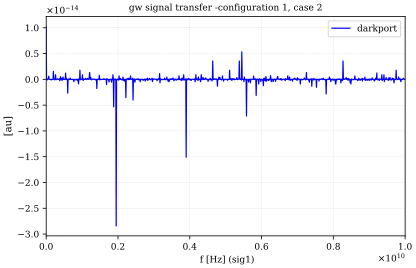

Parsing `nle nle1 10 0 nnle11 nnle12` into pykat object not implemented yet, added as extra line.


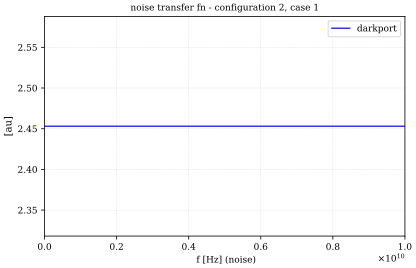

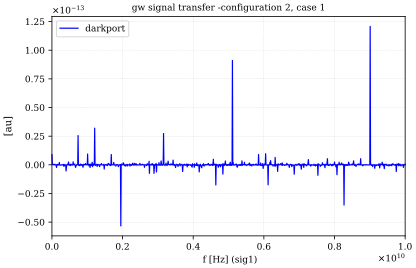

Parsing `nle nle1 10 0 nnle11 nnle12` into pykat object not implemented yet, added as extra line.


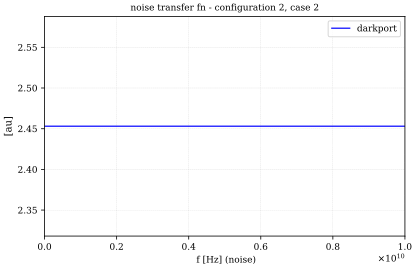

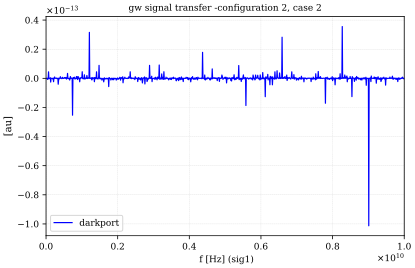

In [8]:
k11 = IFO(1, 53,   "configuration 1, case 1", "_k11.pdf")
k11.transfer_fn_plots()

k12 = IFO(1, 2000, "configuration 1, case 2", "_k12.pdf")
k12.transfer_fn_plots()

k21 = IFO(2, 53,   "configuration 2, case 1", "_k21.pdf")
k21.transfer_fn_plots()

k22 = IFO(2, 2000, "configuration 2, case 2", "_k22.pdf")
k22.transfer_fn_plots()